In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import statsmodels.api as sm
import scipy
import matplotlib as mpl
from amftrack.util.plot import gridplot
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
plt.style.use('presentation.mplstyle')
width = 1.6
height = 1

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure5\PlotsCorentin"
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"
paths = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table = pd.DataFrame()
num_day = 3
for path in paths:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table = pd.concat([table,new])
table["days"] = table["time_since_crossing"] / pd.Timedelta(days=1)
table["3days"] = (table["time_since_crossing"] / pd.Timedelta(days=num_day)).astype(int)
table["days_since_first_image"] = table["days"] - table.groupby("unique_id")[
    "days"
].transform("min")
table["abs_speed-"] = -table["speed-"]

table["speed"] = table[["speed+", "abs_speed-"]].max(1)
grouping = 1
table["lengthdm"] = (np.log2((table["tot_length"]))/grouping).astype(int) * grouping
table["log_tot_num_spores"] = (np.log2((table["tot_num_spore"]))/grouping).astype(int)* grouping
table["log_tot_num_spores"] = (np.log10((table["tot_num_spore"])))

grouping = 1
funtype = 1
time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"

path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['csv_id'] = path
    
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            table_speeds = pd.concat([table_speeds,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))
table_speeds["abs_speed"] = abs(table_speeds['speed']) 
table_speeds = table_speeds.set_index(['csv_id','kymo_id'])
table = table.set_index(['csv_id','kymo_id'])
speedp = table_speeds.loc[table_speeds['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed+'] = mean_speed
speedp = table_speeds.loc[table_speeds['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed-'] = mean_speed
table["mean_speed+"] = table["mean_speed+"].fillna(table["speed+"])
table["mean_speed-"] = table["mean_speed-"].fillna(table["speed-"])
table["ratio"] = -table["mean_speed+"]/table["mean_speed-"]


C:\Users\coren\AppData\Local\Temp\ipykernel_15232\1619894415.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)
C:\Users\coren\AppData\Local\Temp\ipykernel_15232\1619894415.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)


In [3]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_bet_2"
paths_bet = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table_bet = pd.DataFrame()
for path in paths_bet:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table_bet = pd.concat([table_bet,new])
table_bet['days'] = table_bet['time_since_crossing']/pd.Timedelta(days=1)
table_bet["days"] = table_bet["time_since_crossing"] / pd.Timedelta(days=1)
table_bet["3days"] = (table_bet["time_since_crossing"] / pd.Timedelta(days=3)).astype(int)
table_bet["days_since_first_image"] = table_bet["days"] - table_bet.groupby("unique_id")[
    "days"
].transform("min")
table_bet["abs_speed-"] = -table_bet["speed-"]

table_bet["speed"] = table_bet[["speed+", "abs_speed-"]].max(1)
# table_bet["lengthdm"] = (np.log2((table_bet["tot_length"])) / 2).astype(int) * 2
# table_bet["log_tot_num_spores"] = (np.log((table_bet["tot_num_spore"]))).astype(int)
path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds_bet = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths_bet):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    table_loc['csv_id'] = path
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            # subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['normalized_random_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['normalized_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['betweenness'] = table_loc['betweenness'].iloc[j]
            subtable['dist_tip'] = table_loc['dist_tip'].iloc[j]
            subtable['num_nodes_tip'] = table_loc['num_nodes_tip'].iloc[j]
            subtable['is_anastomosing'] = table_loc['is_anastomosing'].iloc[j]
            
            
            
            
            subtable['random_betweenness'] = table_loc['random_betweenness'].iloc[j]
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            
            
            
            

            table_speeds_bet = pd.concat([table_speeds_bet,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
# table_speeds_bet["log_tot_num_spores"] = np.log10((table_speeds_bet["tot_num_spore"]))
table_speeds_bet["abs_speed"] = abs(table_speeds_bet['speed']) 
table_speeds_bet = table_speeds_bet.set_index(['csv_id','kymo_id'])
table_bet = table_bet.set_index(['csv_id','kymo_id'])
speedp = table_speeds_bet.loc[table_speeds_bet['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed+'] = mean_speed
speedp = table_speeds_bet.loc[table_speeds_bet['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed-'] = mean_speed
mean_speed = table_speeds_bet.groupby(['csv_id','kymo_id'])['abs_speed'].mean()
table_bet['mean_speed_abs'] = mean_speed
table_bet["mean_speed+"] = table_bet["mean_speed+"].fillna(table_bet["speed+"])
table_bet["mean_speed-"] = table_bet["mean_speed-"].fillna(table_bet["speed-"])
table_bet["mean_speed_abs"] = table_bet["mean_speed_abs"].fillna(table_bet["speed"])
table_bet['days_without'] = table_bet['days']+(table_bet['unique_id']=="799_20211001")*6
table_speeds_bet['days_without'] = table_speeds_bet['days']+(table_speeds_bet['unique_id']=="799_20211001")*6
table_speeds_bet['log_random_betweenness']=np.log(table_speeds_bet['random_betweenness'])
table_speeds_bet['log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness'])
table_speeds_bet['log_normalized_betweenness']=np.log(table_speeds_bet['normalized_betweenness'])
table_speeds_bet = table_speeds_bet.reset_index()
table_bet = table_bet.reset_index()
table_speeds_bet["dist_tip"]=table_speeds_bet["dist_tip"]*1.725
table_speeds_bet["dist_tip_mm"]=table_speeds_bet["dist_tip"]/1000

# table_speeds_bet['int_log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness']).astype(int)
# table_speeds_bet['int_log_normalized_betweenness']=np.log(table_speeds_bet['normalized_betweenness']).astype(int)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
cmap0 = mpl.cm.get_cmap("viridis")


def bootstrap_linear_fit(df, x_col, y_col,group=None, n_bootstraps=1000, plot_bootstraps=False,ax=None,color=None,x_based_color =False,cmap=cmap0):
    
    if group is None:
        # If no grouping is specified, use the entire dataframe
        group_df = df.copy()
    else:
        # Group the dataframe by the specified column and compute the mean of x and y within each group
        group_df = df.groupby(group).mean(numeric_only=True).reset_index()
    
    x = group_df[x_col]
    y = group_df[y_col]

    # Initialize arrays to store bootstrap results
    bootstrap_slopes = np.zeros(n_bootstraps)
    bootstrap_intercepts = np.zeros(n_bootstraps)

    # Perform bootstrap resampling and linear regression n_bootstraps times
    for i in range(n_bootstraps):
        x_bootstrap, y_bootstrap = resample(x, y)
        lr = LinearRegression()
        lr.fit(x_bootstrap.values.reshape(-1, 1), y_bootstrap)
        bootstrap_slopes[i] = lr.coef_
        bootstrap_intercepts[i] = lr.intercept_

    # Compute the mean and standard error of the bootstrap slopes and intercepts
    slope_mean = np.mean(bootstrap_slopes)
    slope_se = np.std(bootstrap_slopes, ddof=1)
    intercept_mean = np.mean(bootstrap_intercepts)
    intercept_se = np.std(bootstrap_intercepts, ddof=1)
    spores = []
    counts_traj = []
    # Optionally plot all the bootstrap results lines in light grey
    if plot_bootstraps:
        x_min = x.min()
        x_max = x.max()
        sns.regplot(x = x,
            y = y,ax=ax,scatter=False, color=color)
        # plt.gca().collections[-1].set_alpha(0.5)
        
        if not group is None:
            elements = df[group].unique()
            x_values = df[x_col].unique()
            for element in elements:
                width = (np.max(x_values)-np.min(x_values))/len(x_values)
                subselect = df.loc[df[group]==element]
                xpos = subselect[x_col].iloc[0]
                if x_based_color:
                    scale = np.mean((subselect[x_col]-x_min)/(x_max-x_min))
                    color_violin = cmap(scale)
                else:
                    color_violin = "grey"
                parts = ax.violinplot(subselect[y_col],[xpos]
                                      ,widths = width,showextrema=False)
                counts_traj.append(len(subselect))
                spores.append(xpos)
                for pc in parts['bodies']:
                    pc.set_facecolor(color_violin)
                    pc.set_edgecolor("black")
                    pc.set_alpha(0.8) 
                    pc.set_linewidth(0.5) 
        ax.scatter(x,y,color="black",marker="x")
            
                    
                    # pc.set_edgecolor('black')
        # for i in range(n_bootstraps):
        #     y_bootstrap = bootstrap_intercepts[i] + bootstrap_slopes[i] * x
        #     ax.plot(x, y_bootstrap, color='lightgrey', alpha=0.1)
        # y_mean = intercept_mean + slope_mean * x
        # ax.plot(x, y_mean, color=color, linewidth=2)
        # ax.set_xlim(x_min, x_max)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
    return(slope_mean,slope_se,counts_traj,spores)


In [5]:
csvs = [
    "211012_Plate799.csv",
    "211014_Plate809.csv",
    "201217_Plate09.csv",
    "201217_Plate10.csv",
    "201217_Plate38.csv",
    "211013_Plate809.csv",
    "220324_Plate907.csv" ]

In [9]:
mask = table.index.get_level_values('csv_id').isin(csvs)
speeds_BC = table[mask]

In [37]:
speeds_BC

kymo_id  Unnamed: 0  posx  posy   speed+  \
csv_id              video_id                                             
201217_Plate09.csv  1               1           0  5703  3682  11.5570   
                    1               2           1  5703  3682  11.5820   
                    2               3           2  5741  3775  23.2870   
                    2               4           3  5741  3775   5.3667   
                    2               5           4  5741  3775  18.7380   
...                               ...         ...   ...   ...      ...   
220324_Plate907.csv 31             54          53  6076  4316   4.2120   
                    31             55          54  6076  4316   2.4984   
                    32             56          55  5953  4303   3.4437   
                    33             57          56  5844  4294   1.3163   
                    34             58          57  5795  4291   0.0000   

                               speed-  spore_density_1  spore_density_1000  \
csv_id              video_id                                                 
201217_Plate09.csv  1         -9.8998              NaN                 0.0   
                    1        -10.0130              NaN                 0.0   
                    2        -10.7860              NaN                 0.0   
                    2        -11.2620              NaN                 0.0   
                    2        -12.9440              NaN                 0.0   
...                               ...              ...                 ...   
220324_Plate907.csv 31        -2.8493              0.0                 0.0   
                    31        -2.3206              0.0                 0.0   
                    32        -2.5234              0.0                 0.0   
                    33        -2.2406              0.0                 0.0   
                    34         0.0000              0.0                 0.0   

                              spore_density_500  spore_density_num_2000  ...  \
csv_id              video_id                                             ...   
201217_Plate09.csv  1                       0.0                     0.0  ...   
                    1                       0.0                     0.0  ...   
                    2                       0.0                     0.0  ...   
                    2                       0.0                     0.0  ...   
                    2                       0.0                     0.0  ...   
...                                         ...                     ...  ...   
220324_Plate907.csv 31                      0.0                     0.0  ...   
                    31                      0.0                     0.0  ...   
                    32                      0.0                     0.0  ...   
                    33                      0.0                     0.0  ...   
                    34                      0.0                     0.0  ...   

                                  days  3days  days_since_first_image  \
csv_id              video_id                                            
201217_Plate09.csv  1         3.357639      1                     0.0   
                    1         3.357639      1                     0.0   
                    2         3.357639      1                     0.0   
                    2         3.357639      1                     0.0   
                    2         3.357639      1                     0.0   
...                                ...    ...                     ...   
220324_Plate907.csv 31        4.599306      1                     0.0   
                    31        4.599306      1                     0.0   
                    32        4.599306      1                     0.0   
                    33        4.599306      1                     0.0   
                    34        4.599306      1                     0.0   

                              abs_speed-    speed lengthdm lo

In [38]:
test = speeds_BC.reset_index()
test['csv_id'].unique()

array(['201217_Plate09.csv', '201217_Plate10.csv', '201217_Plate38.csv',
       '211012_Plate799.csv', '211013_Plate809.csv',
       '211014_Plate809.csv', '220324_Plate907.csv'], dtype=object)

In [89]:
widths = pd.read_csv("measures_width.csv")
average_radius = widths.groupby(['csv_id','video_id'])['measures'].max()/2
average_radius

csv_id               video_id
201217_Plate09.csv   1           3.367242
                     2           4.055835
                     3           4.363213
                     4           4.314667
                     5           4.213995
                                   ...   
220324_Plate907.csv  30          3.821413
                     31          3.527823
                     32          3.664699
                     33          3.523169
                     34          3.106776
Name: measures, Length: 149, dtype: float64

In [90]:
speeds_BC = speeds_BC.reset_index()
if speeds_BC.index.names != ['csv_id', 'video_id']:
    speeds_BC.set_index(['csv_id', 'video_id'], inplace=True)
if average_radius.index.names != ['csv_id', 'video_id']:
    average_radius.set_index(['csv_id', 'video_id'], inplace=True)
merged_df = pd.merge(speeds_BC, average_radius, on=['csv_id', 'video_id'], how='left')

# Rename the 'measure' column to 'radius' in merged_df if necessary
merged_df.rename(columns={'measures': 'radius'}, inplace=True)
merged_df = merged_df.reset_index()
merged_df = merged_df[merged_df['radius']>0].copy()

In [91]:
merged_df['normalized_betweenness_group']=(merged_df['normalized_betweenness']*10).astype(int)/10
merged_df['radius_group']=(merged_df['radius']).astype(int)

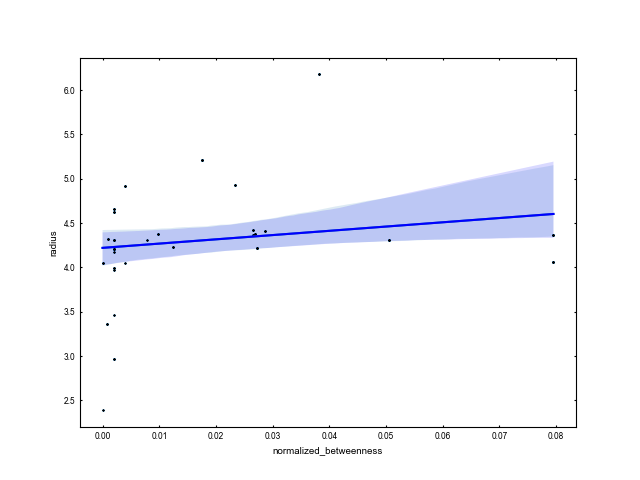

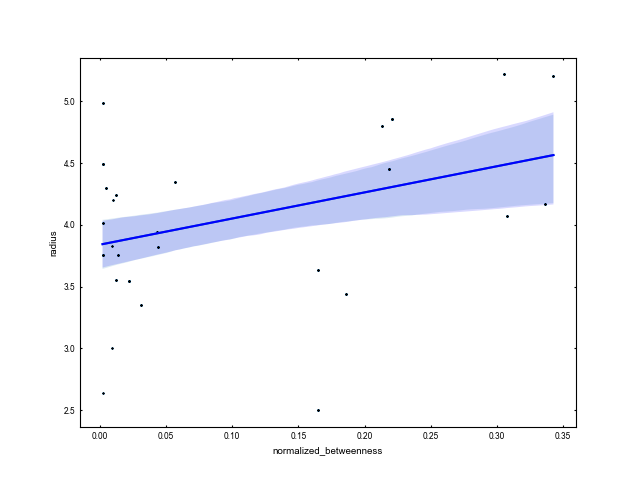

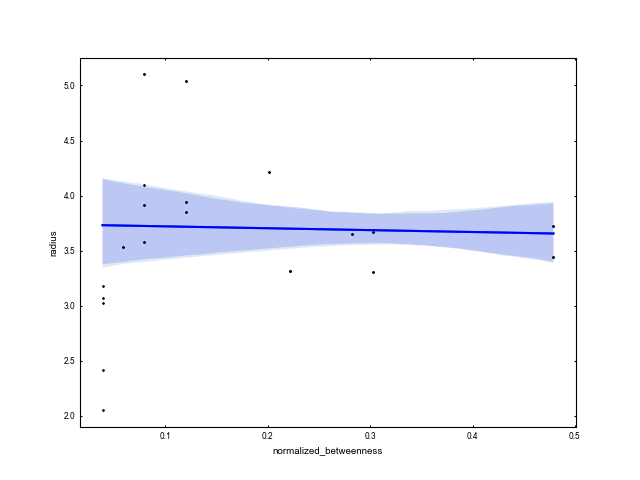

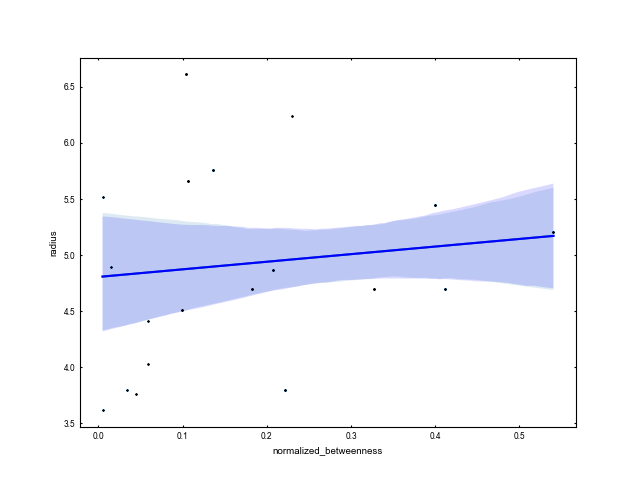

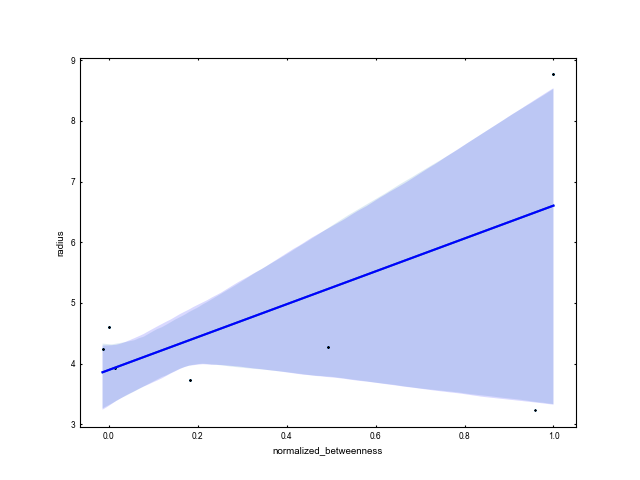

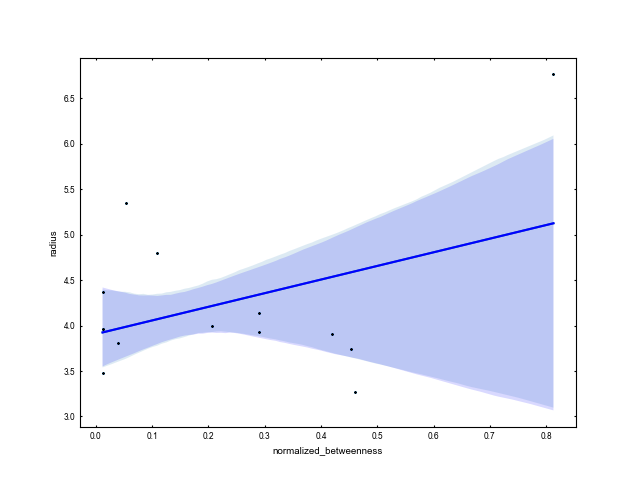

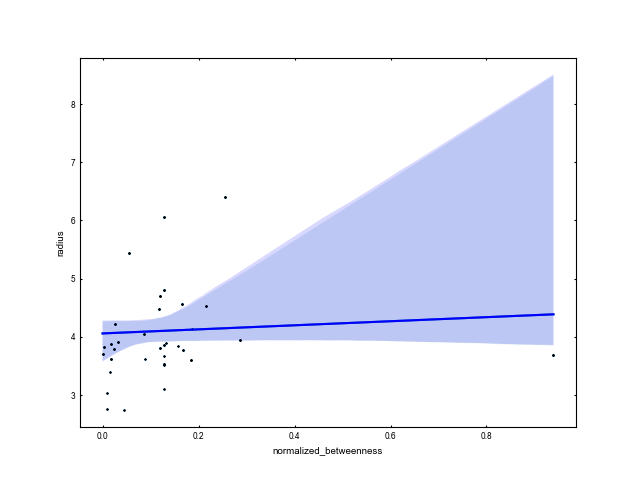

In [130]:

unique_csv_ids = merged_df['csv_id'].unique()
# Create a plot for each csv_id
for csv_id in unique_csv_ids:
    filtered_df = merged_df[merged_df['csv_id'] == csv_id]
    fig, ax = plt.subplots()
    sns.scatterplot(data=filtered_df, x='normalized_betweenness', y='radius', ax=ax)
    sns.regplot(data=filtered_df, x='normalized_betweenness', y='radius', ax=ax)
    slope,slope_std,_,_= bootstrap_linear_fit(filtered_df, 'normalized_betweenness','radius', n_bootstraps=100, plot_bootstraps=plot_bootstrap,ax=ax,color="blue")


In [134]:
filtered_df['max_betweenness']

222    0.002417
223    0.002417
224    0.002417
225    0.002417
226    0.002417
227    0.002417
228    0.002417
229    0.002417
230    0.002417
231    0.002417
232    0.002417
233    0.002417
234    0.002417
235    0.002417
236    0.002417
237    0.002417
238    0.002417
239    0.002417
240    0.002417
241    0.002417
242    0.002417
243    0.002417
244    0.002417
245    0.002417
246    0.002417
247    0.002417
248    0.002417
249    0.002417
250    0.002417
251    0.002417
252    0.002417
253    0.002417
254    0.002417
255    0.002417
256    0.002417
257    0.002417
258    0.002417
259    0.002417
260    0.002417
261    0.002417
262    0.002417
263    0.002417
264    0.002417
265    0.002417
266    0.002417
267    0.002417
268    0.002417
269    0.002417
270    0.002417
271    0.002417
272    0.002417
273    0.002417
274    0.002417
275    0.002417
276    0.002417
277    0.002417
278    0.002417
279    0.002417
Name: max_betweenness, dtype: float64

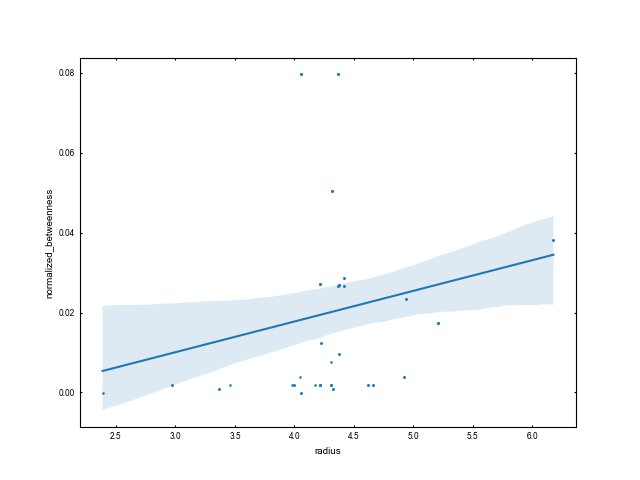

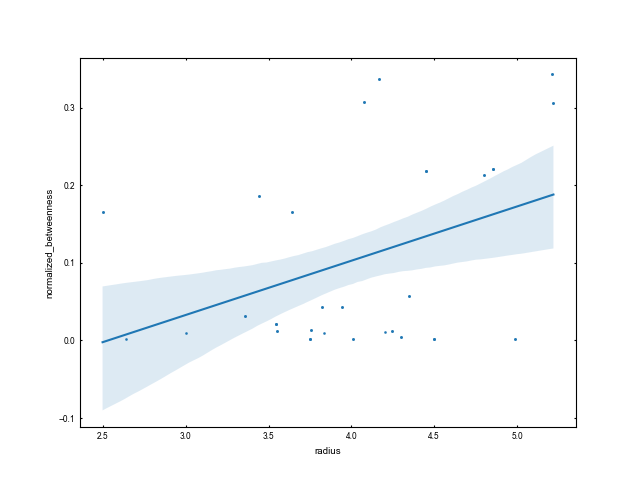

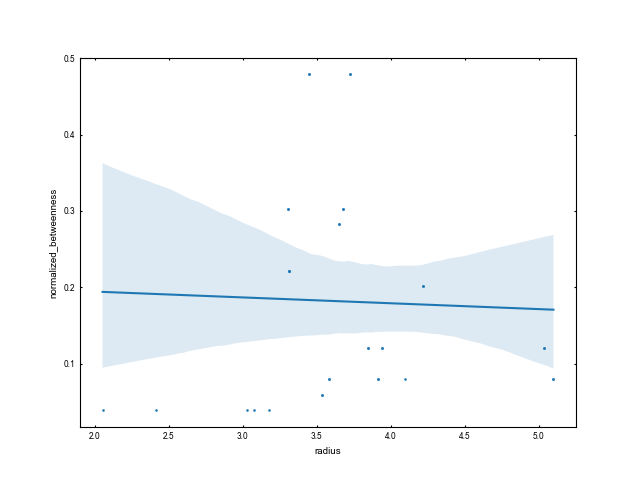

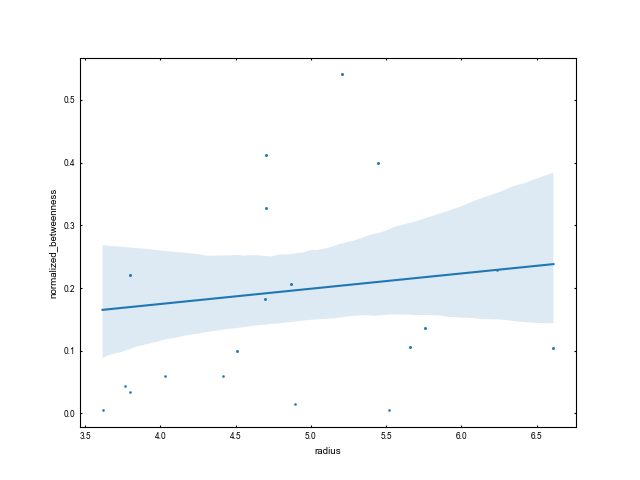

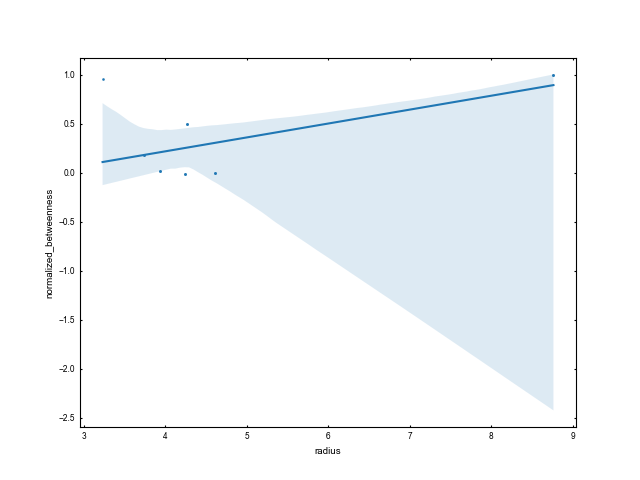

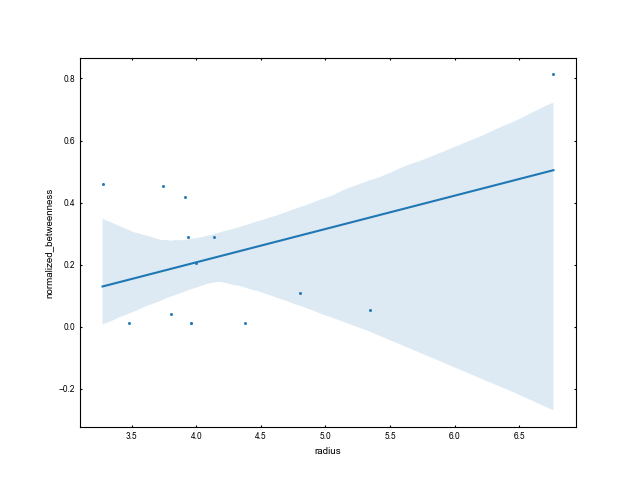

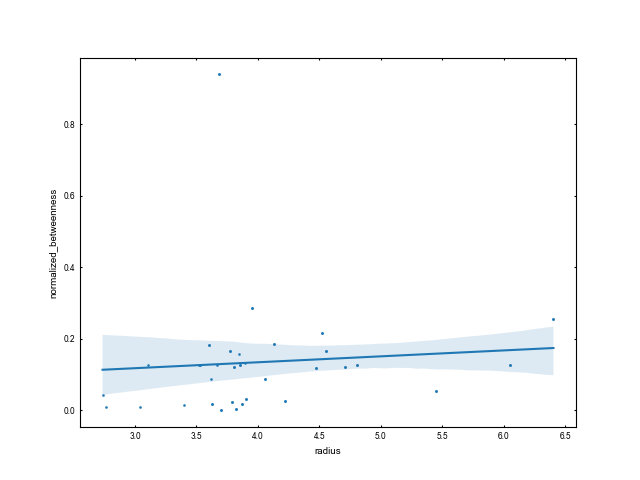

In [170]:

unique_csv_ids = merged_df['csv_id'].unique()
coefs_radius = {}
# Create a plot for each csv_id
for csv_id in unique_csv_ids:
    coefs_radius[csv_id]={}
    fig, ax = plt.subplots()
    # Filter the DataFrame for the current csv_id
    filtered_df = merged_df[merged_df['csv_id'] == csv_id]
    max_BC = filtered_df['max_betweenness'].iloc[0]
    min_BC = filtered_df['min_betweenness'].iloc[0]    
    unique_radius = filtered_df['radius_group'].unique()
    # for i, radius in enumerate(unique_radius):
    #     radius_data = filtered_df[filtered_df['radius_group'] == radius]['normalized_betweenness']
    #     if len(radius_data)>=4:
    #         bp = ax.boxplot(radius_data, positions=[radius], widths=0.5, patch_artist=True, boxprops=dict(facecolor="white"))
    sns.scatterplot(data=filtered_df, x='radius', y='normalized_betweenness', ax=ax)
    sns.regplot(data=filtered_df, x='radius', y='normalized_betweenness', ax=ax)
    
    slope =  filtered_df['radius'].corr(filtered_df['normalized_betweenness'])
    corr_coeffs = []
    for _ in range(200):
        # Resample the DataFrame with replacement
        sample_df = filtered_df.sample(n=len(filtered_df), replace=True)
        # Compute Pearson's correlation coefficient for the resampled DataFrame
        corr = sample_df['radius'].corr(sample_df['normalized_betweenness'])
        corr_coeffs.append(corr)
    # Compute the standard deviation of the bootstrapped correlation coefficients
    slope_std = np.std(corr_coeffs)
    # slope = (slope-min_BC)/(max_BC-min_BC)
    # slope_std = (slope_std-min_BC)/(max_BC-min_BC)
    
    coefs_radius[csv_id][f'radius_slope'] = slope
    coefs_radius[csv_id][f'radius_slope_std'] = slope_std

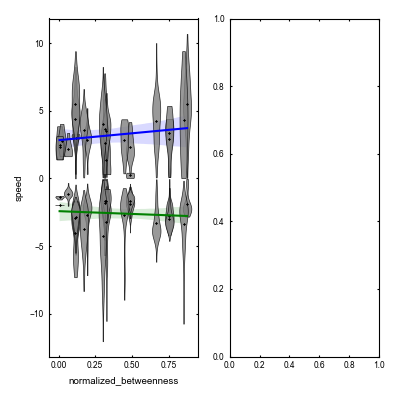

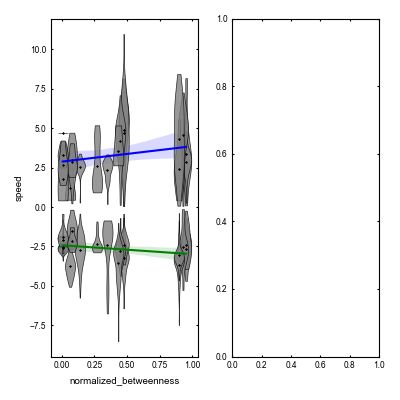

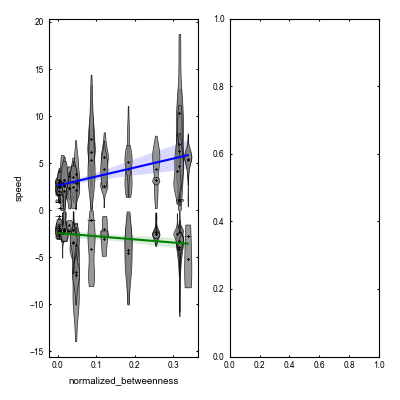

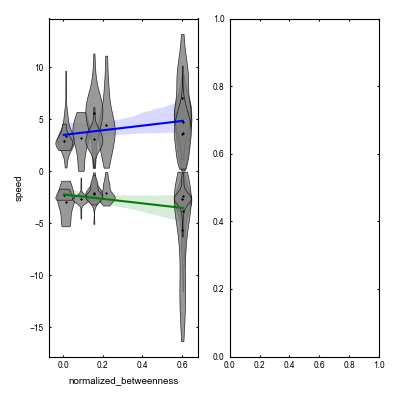

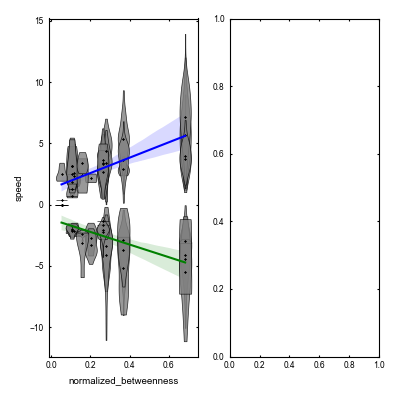

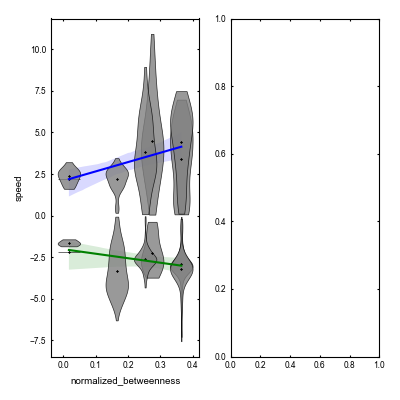

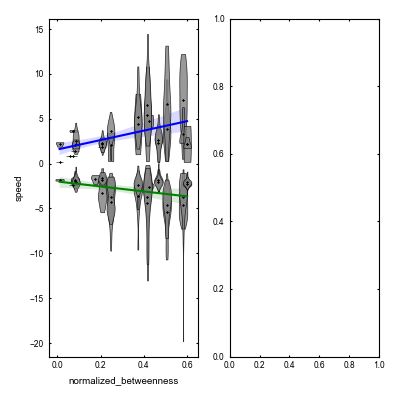

In [112]:
coefs = {}
y_col = "speed"
group = "kymo_id"
x_cols = ["normalized_betweenness"]
plot_bootstrap = True
for csv in csvs:
    coefs[csv]={}
    fig,axs = gridplot(len(x_cols),2,subw = 2,subh=4)
    
    for x_col,ax in zip(x_cols,axs):
        # csv = csvs[index]
        high_bet = table_speeds_bet.loc[table_speeds_bet[x_col]>0]
        selection = high_bet.loc[high_bet['csv_id'] == csv]
        selection = selection.loc[selection["is_anastomosing"] == False]      
        select1 = selection.loc[selection["speed"]>=0]
        slope,slope_std,counts_traj,spores = bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=plot_bootstrap,ax=ax,color="blue")
        coefs[csv][f'{x_col}_slope_up'] = slope
        coefs[csv][f'{x_col}_slope_std_up'] = slope_std
        
        # bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="purple")
        select1 = selection.loc[selection["speed"]<=0]
        slope,slope_std,counts_traj,spores = bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=plot_bootstrap,ax=ax,color="green")
        coefs[csv][f'{x_col}_slope_down'] = slope
        coefs[csv][f'{x_col}_slope_std_down'] = slope_std        # bootstrap_linear_fit(select1, x_col,y_col,group, n_bootstraps=100, plot_bootstraps=True,ax=ax,color="green")
        # ax.set_ylim(-10,10)
        plt.tight_layout()        
    #     break
    # break


In [157]:
def plot_errorbar(x,y,xerr,yerr,ax,color):
    eb1 = ax.errorbar(x, y, fmt='o',elinewidth = 0.2,capsize=0, capthick=0.5,xerr=xerr, yerr=yerr,ecolor=color,color=color)
    eb1[-1][0].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorba,r lines
    eb1[-1][1].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorbar lines
    for shift in [(xerr,0),(-xerr,0),(0,-yerr),(0,yerr)]:
        ax.scatter(x+shift[0],y+shift[1],edgecolor=color,facecolors='none',s=0.5, linewidths=0.1)

In [158]:
data_slope = pd.DataFrame.from_dict(coefs).transpose()
data_slope_r = pd.DataFrame.from_dict(coefs_radius).transpose()
data_slope['mean_slope_BC'] = (data_slope['normalized_betweenness_slope_up'] -data_slope['normalized_betweenness_slope_down'])/2
data_slope['mean_slope_BC_std'] = (data_slope['normalized_betweenness_slope_std_up']+data_slope['normalized_betweenness_slope_std_down'])/2

In [160]:
data_slope_r

,radius_slope,radius_slope_std
201217_Plate09.csv,0.191985,0.085173
201217_Plate10.csv,0.384739,0.119591
201217_Plate38.csv,-0.036177,0.145553
211012_Plate799.csv,0.128383,0.163643
211013_Plate809.csv,0.619792,0.399963
211014_Plate809.csv,0.401293,0.327971
220324_Plate907.csv,0.076087,0.137636


In [161]:
merged_slopes = data_slope_r.merge(data_slope,left_index = True,right_index = True)

In [165]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'


In [172]:
np.mean(merged_slopes['radius_slope'])

0.25230036307685383

2024-02-02 19:10:01,787-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


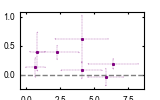

In [166]:
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
symbols = ['o', 's', '*', 'D', 'X', 'P', 'v']
data_slope = merged_slopes
x_col1 = "mean_slope_BC"
x_col2 = "radius_slope"
x_col1_std = "mean_slope_BC_std"
x_col2_std = "radius_slope_std"
fig,ax = plt.subplots(figsize = (width,height))

x1,y1 = data_slope[x_col1],data_slope[x_col2]
x_error1,y_error1 = data_slope[x_col1_std],data_slope[x_col2_std]
ax.scatter(x1, y1,color = "purple")

# eb1 = ax.errorbar(x1, y1, xerr=x_error1, yerr=y_error1,
#                   fmt='o',elinewidth = 1,capsize=0.5, capthick=0.5,ecolor="purple",color="purple",uplims = True,xuplims=True,xlolims =True,lolims =True)
eb1 = ax.errorbar(x1, y1, fmt='o',elinewidth = 0.2,capsize=0, capthick=0.5,xerr=x_error1, yerr=y_error1,ecolor="purple",color="purple")
eb1[-1][0].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorba,r lines
eb1[-1][1].set_linestyle('dotted') #eb1[-1][0] is the LineCollection objects of the errorbar lines

plot_errorbar(x1,y1,x_error1, y_error1,ax,"purple")

# ax.hlines(0,-8e-4,8e-4,color="grey",linestyle ="--")
ax.set_ylabel(r"$R(r,BC)$ ")
ax.set_xlabel(r"$\Delta v/\Delta BC$ ($\mu m$ $ s^{-1}$)")
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
# ax.xaxis.offsetText.set_visible(False)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'5F.png'))
ax.axhline(y=0, color="grey", linestyle="--")  # add a horizontal line at y=0

plt.savefig(os.path.join(path_figure,'rebutal_BC_r.pdf'), bbox_inches='tight',transparent=True)